Integrantes de el equipo:
* Ambrocio Loreto Luis Manuel 
* Hernández Molina Marlene Zoobeida 

¿De qué se trata?  

Descripción del contexto de la analogía  

Edward, un director de prisión empieza a escribir cuentos, así que comienza a publicar la última palabra de su novela para que el trabajo de los reclusos sea que actualicen individualmente sus opiniones sobre el estado actual de la historia, basados en la nueva palabra y las opiniones de los internos del día anterior. Para crear sus propias opiniones primero, deciden cuántas opiniones de ayer desean olvidar, utilizando la información de la nueva palabra y la opiniones de otros presos en la celda. También deciden cuánto de esto quieren mezclar con las viejas opiniones que han elegido continuar desde el día anterior.

Esta analogía es usada para una de las tecnicas de aprendizaje profundo utilizando datos secuenciales, como texto, la red neuronal a corto plazo (LSMT) que es un tipo particular de red recurrente RNN, utilizando este tipo de red no sufre del problema del degradado del gradiente (desaparición). Aquí la idea es generar texto en el estilo de las fábulas de Aesop (Esopo)-Las Fábulas de Esopo, por Aesop y George Fyler Townsend.

Las RNN contiene una capa recurrente (o celda) que puede manejar los datos secuenciales haciendo su propia salida en un paso de tiempo particular y estas forman parte de la entrada en la siguiente etapa temporal, de modo que la información del pasado puede afectar la predicción en el tiempo actual. Mientras las redes recurrentes estándar pueden modelar dependencias a corto plazo , las LSTM pueden aprender dependencias largas, por lo que se podría decir que tienen una «memoria» a más largo plazo.

A el momento de generar texto el orden de las palabras es muy importante,por ejemplo en una oración las palabras no tendrían sentido a la inversa. Además, a menudo hay dependencias secuenciales a largo plazo entre palabras que deben ser capturadas porel modelo: por ejemplo, la respuesta a una pregunta o llevar adelante el contexto de un pronombre, es por esto que las redes LSTM son muy utilizadas para generar texto.

In [ ]:
import numpy as np #Importar libreria numpy
import re #Proporciona operaciones de coincidencia de expresiones regulares, permite el uso de caracteres especiales sin invocar su significado especial
from IPython.display import clear_output #Añade funcionalidades extra al modo interactivo, en este caso borrar la salida de una celda
import pandas as pd
from keras.layers import Dense, LSTM, Input, Embedding, Dropout #De la libreria keras, se utilizaran los modulos Dense, LSTM, Input, Embedding, Dropout 
#Dense: implementa la operación output = activation(dot(input, kernel) + bias), donde activation es el arguendo de la funcion de activacion, karnel es una matriz de ponderaciones por laas capas anteriores y el sesgo como ultimo parametro 
#LSTM: Long Short-Term Memory layer (Capa de memoria a corto plazo)
#Imput: se utiliza para instanciar un tensor de Keras, esto es un objeto matemático que almacena valores numéricos y que pueden tener distintas dimensiones.
#Embedding: este modulo convierte números enteros positivos (índices) en vectores densos de tamaño fijo.
from keras.utils import np_utils
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop #Utilizando esta libreria para acceder a los algoritmos de optimizacioni Adam y RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer # Tokenizer provee un analizador léxico, este analizador también retorna comentarios como tokens
from keras.callbacks import LambdaCallback
from tensorflow import keras

In [ ]:
 load_saved_model = True
train_model = False
token_type = 'word'

In [ ]:


#load in the text and perform some cleanup
#cargue el texto y realice una limpieza
seq_length = 20  #Se le asigna un valor a la longitud de secuencia, dividimos el texto en trozos de 20 palabras.

filename = './datos/data.txt' #usando los datos
 
with open(filename, encoding='utf-8-sig') as f:
    text = f.read()
    
#eliminar texto antes y después de las historias principales  
#removing text before and after the main stories
start = text.find("THE FOX AND THE GRAPES\n\n\n") #Decide donde comenzar 
end = text.find("ILLUSTRATIONS\n\n\n[") #Decide donde terminar
text = text[start:end]

El primer paso es limpiar y tokenizar el texto. La tokenización es el proceso de dividir el texto en unidades individuales, como palabras(hay un token por cada palabra diferente en el texto) o caracteres.
Para este ejemplo, usaremos la tokenización por palabras en minúscula(todos los caracteres se convierten a minúscula), sin derivación de palabras(derivación de palabra es como tomamos como un mismo token a los diferentes tiempos de un verbo, por ejemplo con derivación de palabra las palabras browse, browsing, browses, y browsed se deberian tokenizar a brows). También tokenizaremos los signos de puntuación, ya que nos gustaría que el modelo prediga cosas como cuándo finalizar las oraciones. Finalmente, reemplazaremos los múltiples saltos de linea entre historias con un bloque de caracteres de nueva historia, ||||||||||||||||||||. De esta manera, cuando generamos texto con el modelo, el modelo sabrá cuando comenzar una nueva historia desde cero.

In [ ]:
start_story = '| ' * seq_length
    
text = start_story + text
text = text.lower() #convirtiendo todos los caracteres en mayúsculas del texto en caracteres en minúsculas 
text = text.replace('\n\n\n\n\n', start_story) #remplaza los saltos de linea
text = text.replace('\n', ' ') #remplaza 
text = re.sub('  +', '. ', text).strip() #eliminando todos los espacios en blanco iniciales y finales del texto
text = text.replace('..', '.')

text = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~])', r' \1 ', text) #método re.sub(pattern, repl, string, count=0) toma la string como entrada y reemplaza las ocurrencias de pattern con la repl. 
text = re.sub('\s{2,}', ' ', text) 
len(text)  ##longitud del texto

213716

In [ ]:

if token_type == 'word': #cambia cada texto en una secuencia de números enteros cada número entero es el índice de un token, en este caso el tipo de token es 'word'
    tokenizer = Tokenizer(char_level = False, filters = '')
else:
    tokenizer = Tokenizer(char_level = True, filters = '', lower = False) #vectoriza un corpus de texto
    
tokenizer.fit_on_texts([text])  #actualizando el vocabulario interno basado en la lista de texto

total_words = len(tokenizer.word_index) + 1

token_list = tokenizer.texts_to_sequences([text])[0] 

total_words #total de tokens del texto

4169

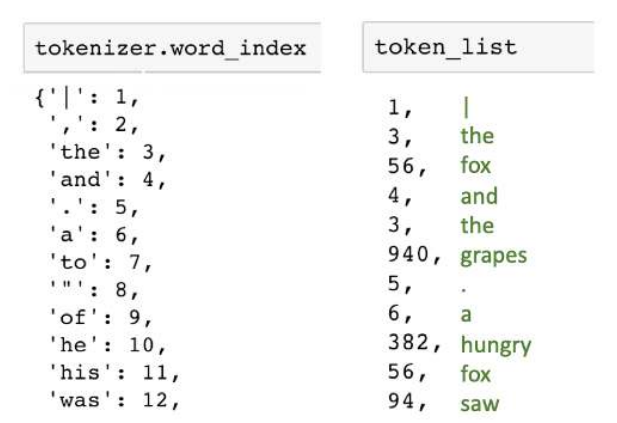

In [ ]:
print(tokenizer.word_index)
print(token_list)
len(token_list)#total de palabras

{'|': 1, ',': 2, 'the': 3, 'and': 4, '.': 5, 'a': 6, 'to': 7, '"': 8, 'of': 9, 'he': 10, 'his': 11, 'was': 12, 'you': 13, 'in': 14, 'him': 15, 'it': 16, 'for': 17, 'i': 18, 'but': 19, 'that': 20, 'with': 21, 'said': 22, 'they': 23, 'at': 24, 'as': 25, 'when': 26, 'on': 27, 'so': 28, 'by': 29, ':': 30, 'one': 31, 'had': 32, ';': 33, 'be': 34, 'them': 35, 'up': 36, 'all': 37, 'who': 38, '-': 39, 'her': 40, 'my': 41, 'is': 42, 'out': 43, 'me': 44, 'not': 45, 'your': 46, 'were': 47, 'which': 48, 'have': 49, 'their': 50, 'no': 51, 'lion': 52, 'she': 53, 'if': 54, 'into': 55, 'fox': 56, 'an': 57, 'what': 58, 'ass': 59, '!': 60, 'time': 61, 'from': 62, 'are': 63, 'came': 64, '?': 65, 'man': 66, 'do': 67, 'about': 68, 'there': 69, 'wolf': 70, 'then': 71, 'upon': 72, 'himself': 73, 'this': 74, 'day': 75, 'would': 76, 'some': 77, 'once': 78, 'will': 79, 'very': 80, 'went': 81, 'well': 82, 'than': 83, 'down': 84, 'replied': 85, 'got': 86, 'off': 87, 'could': 88, 'away': 89, 'see': 90, 'good': 91,

50436

Nuestra red LSTM estará capacitada para predecir la siguiente palabra en una secuencia, dado una secuencia de palabras que preceden a este punto, la longitud de la secuencia que utilizamos para entrenar el modelo es un parámetro del proceso de capacitación. En este ejemplo, elegimos usar una longitud de secuencia de 20, por lo que dividimos el texto en trozos de 20 palabras. Se pueden construir un total de 50416 secuencias, por lo que nuestro conjunto de datos de entrenamiento $X$ es una matriz de tamaño [50416, 20].
La variable de respuesta para cada secuencia es la palabra posterior, la salidad es un vector de longitud 4,169 (el número de palabras distintas en el vocabulario, a este tipo de representación se le conoce como hot encoding). Por lo tanto, nuestra respuesta $Y$ es una matriz binaria tamaño [50416, 4169], las matrices $X$ y $Y$ se obtendran en el siguiente codigo

In [ ]:
def generate_sequences(token_list, step):
    
    X = []
    y = []

    for i in range(0, len(token_list) - seq_length, step):
        X.append(token_list[i: i + seq_length])
        y.append(token_list[i + seq_length])

    y = np_utils.to_categorical(y, num_classes = total_words) #Convierte un vector de clase enteros (los numeros enteros que se le asignaron a las palabras del texto) en una matriz de clase binaria.
    
    num_seq = len(X)
    print('Number of sequences:', num_seq, "\n")
  #Ya que se divio la longitud del texto en trozos de 20 palabras se pueden construir un total de 50.416 secuencias de este tipo
    return X, y, num_seq

step = 1
seq_length = 20

X, y, num_seq = generate_sequences(token_list, step)

X = np.array(X)  # Crea un array a partir de la lista x
y = np.array(y)  # Crea un array a partir de la lista y


Number of sequences: 50416 



In [ ]:
X.shape #dimensiones del array creado de los datos de entrenamiento X

(50416, 20)

In [ ]:
y.shape #La variable de respuesta para cada secuencia es la palabra subsiguiente, codificada en un vector de longitud 4.169 (el número de palabras distintas en el vocabulario)

(50416, 4169)

## Define the LSTM model

 La entrada al modelo es una secuencia de tokens  y la salida es la probabilidad de que cada palabra en el vocabulario aparezca a continuación en la secuencia.Debemos introducir dos nuevos tipos de capas, embedding y LSTM.
 Un enbedding(o incruste) de palabras es una representacion de el texto donde las palabras que tienen el mismo significado tienen una representación similar,  las palabras individuales se representan como vectores de valor real en una dimensión predefinida. cada palabra se mapea a un vector y palabras similares se pueden representar en vectores similares, esto sirve mucho pues se le da importancia a el hecho de que hay palabras con siginificado similar aunque textualmente no tengan similitudes.

La capa de embedding es una capa que se entrena para poder realizar el enbedding de palabras, el número de pesos aprendidos por esta capa es igual al tamaño del vocabulario, multiplicado por Embedding_Size, en la siguiente imagen se puede representar esta parte 

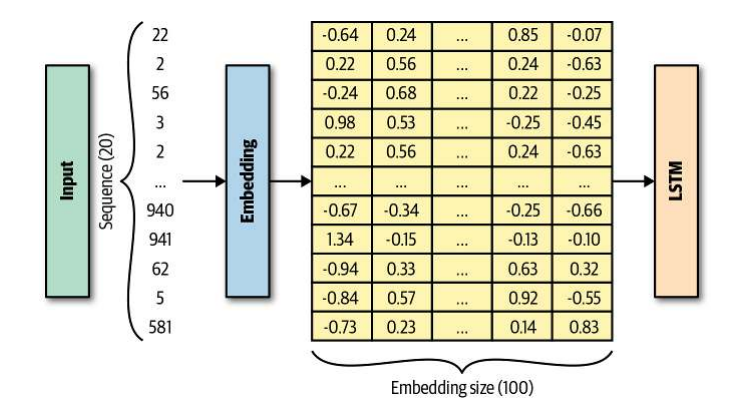



Como ya dijismos una capa recurrente tiene la propiedad especial de poder procesar datos de entrada secuenciales $[x_1, ..., x_n]$. Consiste en una célula que actualiza su estado oculto, $H_T$, ya que cada elemento de la secuencia $X_T$ se pasa a través de él, un tiempo de tiempo a la vez. El estado oculto es un vector con longitud igual al número de unidades en la célula, se puede considerar como la comprensión actual de la célula de la secuencia. En el momento del paso $T$, la celda utiliza el valor anterior del estado $H_{T-1}$ oculto junto con los datos de la hora actual. $X_T$ para producir un vector de estado oculto actualizado $H_T$. Este proceso recurrente continúa hasta el final de la secuencia. Una vez que se termina la secuencia, la capa emite el estado final oculto de la célula, $H_N$, que luego se transmite a la siguiente capa de la red, en la siguiente imagen se puede ver esto 

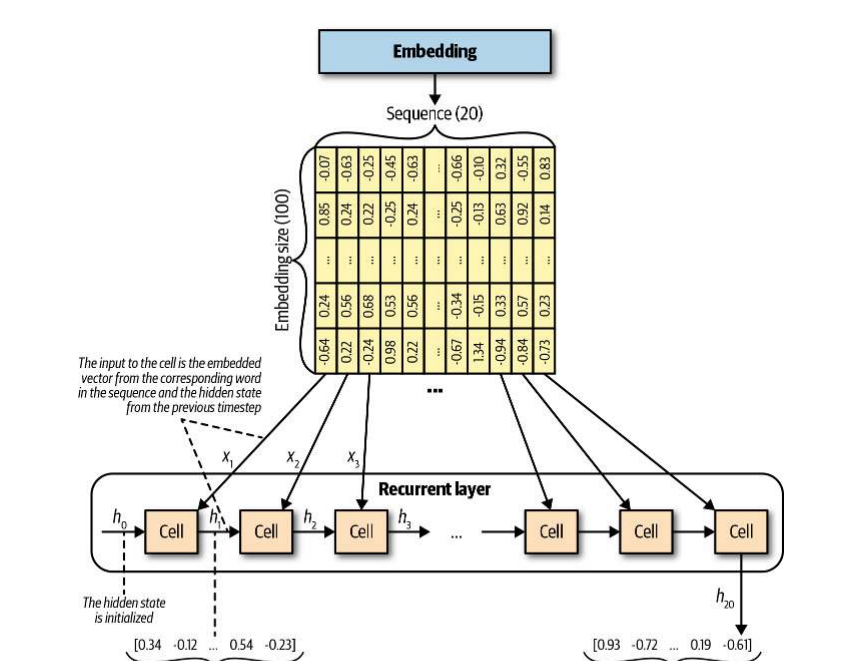

In [ ]:
#introducir dos nuevos tipos de capas, Embedding y LSTM

if load_saved_model:
    
    model1 = load_model('./datos/model1.h5')#carga el modelo por si esta guardado

else:

    n_units = 256
    embedding_size = 100 #dimensión de el vector de enbedding

    text_in = Input(shape = (None,))
    embedding = Embedding(total_words, embedding_size)
    x = embedding(text_in) #capa enbedding
    x = LSTM(n_units)(x) #capa LSTM
    # x = Dropout(0.2)(x)
    text_out = Dense(total_words, activation = 'softmax')(x)

    model1 = Model(text_in, text_out)

    opti = RMSprop(learning_rate = 0.001)
    model1.compile(loss='categorical_crossentropy', optimizer=opti)

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         416900    
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense (Dense)               (None, 4169)              1071433   
                                                                 
Total params: 1,853,901
Trainable params: 1,853,901
Non-trainable params: 0
_________________________________________________________________


La red emitirá un conjunto de probabilidades para cada palabra de la que podamos probar.Por lo tanto, podemos hacer que la generación de texto sea estocástica, en lugar de determinista. Además, podemos introducir un parámetro de temperatura al proceso de muestreo para indicar cuán deterministas nos gustaría que  el proceso sea.

In [ ]:
#Esta función pesa las salidas con un factor de escalado de temperatura antes de
#reaparecer la función SoftMax. Una temperatura cercana a cero hace que el muestreo 
#sea más determinista (es decir, la palabra con mayor probabilidad es muy elegida), 
#mientras que una temperatura de 1 significa que cada palabra se elija con la salida de probabilidad por el modelo.

def sample_with_temp(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def generate_text(seed_text, next_words, model, max_sequence_len,temp):
    output_text = seed_text
    
    seed_text = start_story + seed_text #seed_text es una cadena de palabras que le
    # gustaría dar a el modelo para iniciar el proceso de generación(puede estar en blanco)
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0] #Las palabras se convierten a una lista de tokens
        token_list = token_list[-max_sequence_len:] #Sólo se mantienen los últimos tokens max_sequence_len
        token_list = np.reshape(token_list, (1, max_sequence_len))
        
        probs = model.predict(token_list, verbose=0)[0] #El modelo emite las probabilidades 
        y_class = sample_with_temp(probs, temperature = temp)#se elige la adecuada 
      
        
        if y_class == 0:
          output_word = '' 
        else:
          output_word = tokenizer.index_word[y_class] #obtiene la siguiente palabra 
        if output_word == "|": #Si la palabra de salida es el token de inicio de la historia,
          break              # dejamos de generar más palabras, ya que este es la forma que nos dice que quiere terminar esta historia y comenzar la siguiente!
            
            
        if token_type == 'word':
          output_text += output_word + ' ' #concatena las palabras 
          seed_text += output_word + ' '
        else:
          output_text += output_word + ' '
          seed_text += output_word + ' '
            
            
    return output_text

In [ ]:
def on_epoch_end(epoch, logs):
    seed_text = ""
    gen_words = 500
    #probamos con varios parametros para temp 
    print('Temp 0.2')
    print (generate_text(seed_text, gen_words, model1, seq_length, temp = 0.2))
    print('Temp 0.33')
    print (generate_text(seed_text, gen_words, model1, seq_length, temp = 0.33))
    print('Temp 0.5')
    print (generate_text(seed_text, gen_words, model1, seq_length, temp = 0.5))
    print('Temp 1.0')
    print (generate_text(seed_text, gen_words, model1, seq_length, temp = 1))

   
# entrenamiento de el modelo

if train_model:
    epochs = 1000
    batch_size = 32
    num_batches = int(len(X) / batch_size)
    model1.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle = True)
    model1.save('./datos/model1.h5')

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         416900    
                                                                 
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense (Dense)               (None, 4169)              1071433   
                                                                 
Total params: 1,853,901
Trainable params: 1,853,901
Non-trainable params: 0
_________________________________________________________________


# Propuesta


In [ ]:
import nltk #su uso es para el análisis lingüístico de documentos y en el procesamiento de lenguaje natural
from gensim.models import Word2Vec,FastText #Word2Vec algoritmo para aprender una palabra incrustada de un corpus de texto.
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.poincare import PoincareModel, PoincareRelations
from gensim.test.utils import datapath
from gensim.test.utils import get_tmpfile

n_units = 256
embedding_size = 100 #dimensión de el vector de enbedding

train_embeddings=False

## word2vec

Primero se realiza el embbeding luego se transforma la matriz X de dos dimenciones a una matriz de 3 dimenciones, en este caso la matriz X era de n_secuencias$\times$tamaño_secuencia, y nuestra nueva matriz incluira el embbeding por lo tanto será de n_secuencias$\times$tamaño_secuencia$\times$tamaño_embbeding 

Usado alguno de los dos algoritmos incorporados: Continuous Bagof-Words (CBOW) y Skip-Gram.
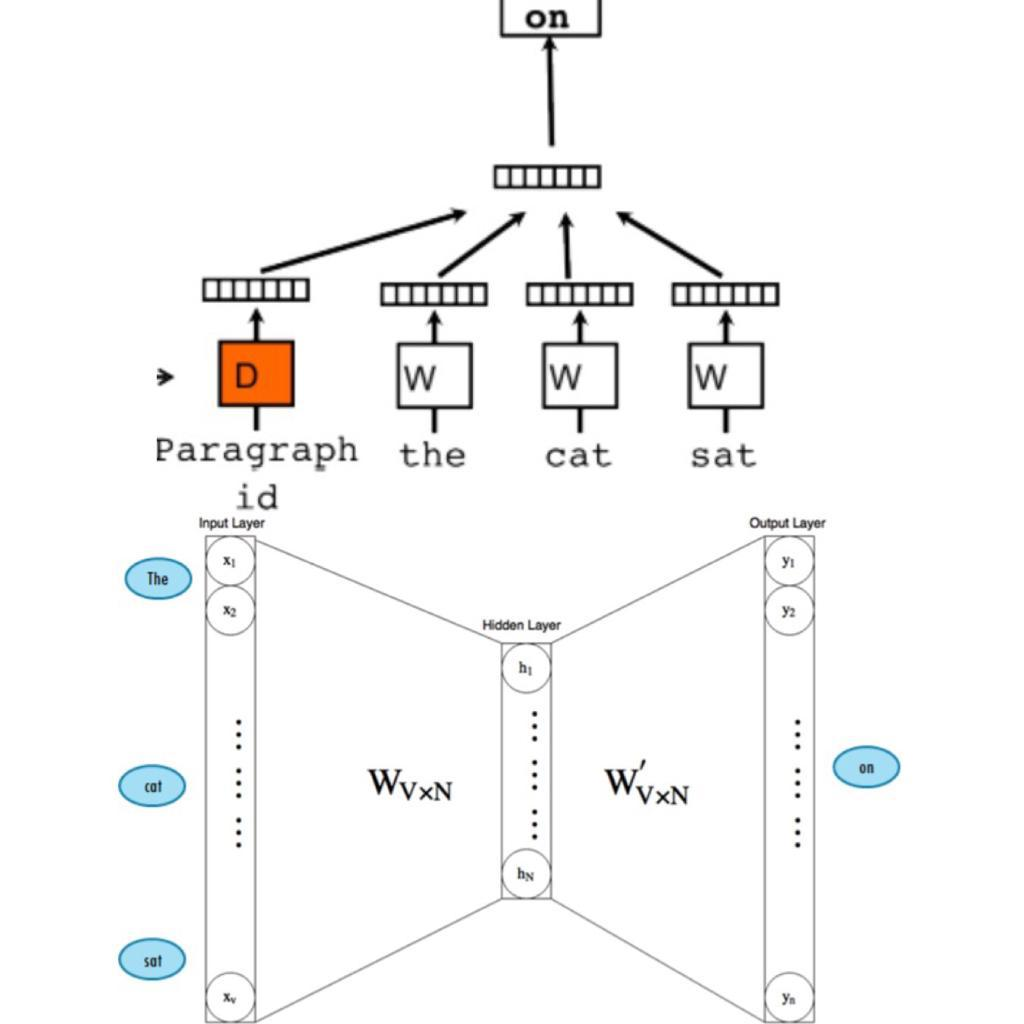


In [ ]:

nltk.download('punkt') #"punkt" contiene modelos para la tokenización de textos
all_sentences = nltk.sent_tokenize(text)

all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
all_words.append(["don't","i'm","it's","i'll","can't","didn't","won't","that's","hadn't","couldn't",
 'cannot',"you'll","lion's","wouldn't","you're","i've","wasn't","he's","there's",
 "what's","fox's","eagle's","you'd","butcher's","master's","mother's","we've",
 "shan't","wolf's","shepherd's","ass's","jupiter's","i'd","it'll","other's","farmer's",
 "needn't","let's","there'll","haven't","men's","doesn't","they're","isn't","clown's",
 "you've","man's","water's","mouse's","weren't","sheep's","aren't","we're","frogs'",
 "he'll","slave's","death's","neighbours'","sculptor's","nightingale's","they'll",
 "owner's","who'll","one's","carpenter's","day's","rider's","apollo's","patient's",
 "summer's","they'd","son's","mule's","brother's","labourer's","snake's","gardener's",
 "potter's","others'","grasshoppers'","gardner's","here's","wits'","æsop's","winter's",
 "shouldn't","where's","heart's","spider's","hasn't","stag's",'"'])#palabras que no se pudieron 
                                                                  #tokenizar de forma correcta

n_units = 256
embedding_size = 100 #dimensión de el vector de enbedding

if train_embeddings:
  word2vec = Word2Vec(all_words, min_count=0,size=embedding_size)
  word2vec.save('./datos/mod_emb_w2v')
else:
  word2vec=Word2Vec.load('./datos/mod_emb_w2v')
  

new_X= np.zeros((X.shape[0], X.shape[1], embedding_size))
for i in range(new_X.shape[0]):
  for j in range(new_X.shape[1]):
    st=tokenizer.sequences_to_texts([[X[i,j]]])
    new_X[i,j]=word2vec.wv[st] #sustituye el valor de el token en X, por el vector reultante de realizar embbeding 


      
new_X[0]

def generate_text_2(seed_text, next_words, model, max_sequence_len, temp, mod_emb):
    output_text = seed_text
    
    seed_text = start_story + seed_text #seed_text es una cadena de palabras que le
    # gustaría dar a el modelo para iniciar el proceso de generación(puede estar en blanco)
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0] #Las palabras se convierten a una lista de tokens
        token_list = token_list[-max_sequence_len:] #Sólo se mantienen los últimos tokens max_sequence_len
        token_list = np.reshape(token_list, (1, max_sequence_len))

        embb=np.zeros((1, max_sequence_len, embedding_size))
        for i in range(max_sequence_len):
          st=tokenizer.sequences_to_texts([[token_list[0,i]]])
          embb[0,i]=mod_emb.wv[st]  
        
        probs = model.predict(embb, verbose=0)[0] #El modelo emite las probabilidades 
        y_class = sample_with_temp(probs, temperature = temp)#se elige la adecuada 
        
        if y_class == 0:
            output_word = ''
        else:
            output_word = tokenizer.index_word[y_class] #obtiene la siguiente palabra 
            
        if output_word == "|": #Si la palabra de salida es el token de inicio de la historia,
            break              # dejamos de generar más palabras, ya que este es la forma que nos dice que quiere terminar esta historia y comenzar la siguiente!
            
            
        if token_type == 'word':
            output_text += output_word + ' ' #concatena las palabras 
            seed_text += output_word + ' '
        else:
            output_text += output_word + ' '
            seed_text += output_word + ' '
            
            
    return output_text

def on_epoch_end_w2v(epoch, logs):
  seed_text = ""
  gen_words = 500
  #probamos con varios parametros para temp 
  print('Temp 0.2')
  print (generate_text_2(seed_text, gen_words, model2, seq_length, temp = 0.2, mod_emb=word2vec))
  print('Temp 0.33')
  print (generate_text_2(seed_text, gen_words, model2, seq_length, temp = 0.33,mod_emb=word2vec))
  print('Temp 0.5')
  print (generate_text_2(seed_text, gen_words, model2, seq_length, temp = 0.5,mod_emb=word2vec))
  print('Temp 1.0')
  print (generate_text_2(seed_text, gen_words, model2, seq_length, temp = 1,mod_emb=word2vec))
  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def generate_text_2(seed_text, next_words, model, max_sequence_len, temp, mod_emb):
    output_text = seed_text
    
    seed_text = start_story + seed_text #seed_text es una cadena de palabras que le
    # gustaría dar a el modelo para iniciar el proceso de generación(puede estar en blanco)
    
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0] #Las palabras se convierten a una lista de tokens
        token_list = token_list[-max_sequence_len:] #Sólo se mantienen los últimos tokens max_sequence_len
        token_list = np.reshape(token_list, (1, max_sequence_len))

        embb=np.zeros((1, max_sequence_len, embedding_size))
        for i in range(max_sequence_len):
          st=tokenizer.sequences_to_texts([[token_list[0,i]]])
          embb[0,i]=mod_emb.wv[st]  
        
        probs = model.predict(embb, verbose=0)[0] #El modelo emite las probabilidades 
        y_class = sample_with_temp(probs, temperature = temp)#se elige la adecuada 
        
        if y_class == 0:
            output_word = ''
        else:
            output_word = tokenizer.index_word[y_class] #obtiene la siguiente palabra 
            
        if output_word == "|": #Si la palabra de salida es el token de inicio de la historia,
            break              # dejamos de generar más palabras, ya que este es la forma que nos dice que quiere terminar esta historia y comenzar la siguiente!
            
            
        if token_type == 'word':
            output_text += output_word + ' ' #concatena las palabras 
            seed_text += output_word + ' '
        else:
            output_text += output_word + ' '
            seed_text += output_word + ' '
            
            
    return output_text

El modelo sera similar a el anterior, solo que no tendrá la capa de embbeding y la matriz de entrada será de 3 dimensiones 

In [ ]:
n_units = 256
embedding_size = 100 #dimensión de el vector de enbedding

model2 = keras.models.Sequential()
model2.add(LSTM(n_units, input_shape=(new_X.shape[1],new_X.shape[2])))
model2.add(Dense(total_words, activation = 'softmax'))

opti = RMSprop(learning_rate = 0.001)
model2.compile(loss='categorical_crossentropy', optimizer=opti)

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               365568    
                                                                 
 dense (Dense)               (None, 4169)              1071433   
                                                                 
Total params: 1,437,001
Trainable params: 1,437,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#entrenamiento de el modelo
if train_model:
  epochs = 1000
  batch_size = 32
  num_batches = int(len(new_X) / batch_size)
  callback = LambdaCallback(on_epoch_end=on_epoch_end_w2v)
  model2.fit(new_X, y, epochs=epochs, batch_size=batch_size, shuffle = True)
  model2.save('./datos/model2.h5')
else:
  model2 = load_model('./datos/model2.h5')

##FastText
Es una técnica de representación de vectores desarrollada por Facebook AI Research.
Puede derivar vectores de palabras para palabras desconocidas o fuera del vocabulario esto se debe a aprende detalles morfológicos.

In [ ]:

embedding_size=100
if train_embeddings:
  fastext=FastText(size=embedding_size, min_count=1, sentences=all_words)
  fastext.save('./datos/mod_emb_ft')
else: 
   fastext = FastText.load('./datos/mod_emb_ft')


new_X2= np.zeros((X.shape[0], X.shape[1], embedding_size))
for i in range(new_X2.shape[0]):
  for j in range(new_X2.shape[1]):
    st=tokenizer.sequences_to_texts([[X[i,j]]])
    new_X2[i,j]=fastext.wv[st] #sustituye el valor de el token en X, por el vector reultante de realizar embbeding 
      
new_X2[0]


def on_epoch_end_ft(epoch, logs):
  seed_text = ""
  gen_words = 500
  #probamos con varios parametros para temp 
  print('Temp 0.2')
  print (generate_text_2(seed_text, gen_words, model3, seq_length, temp = 0.2, mod_emb=fastext))
  print('Temp 0.33')
  print (generate_text_2(seed_text, gen_words, model3, seq_length, temp = 0.33,mod_emb=fastext))
  print('Temp 0.5')
  print (generate_text_2(seed_text, gen_words, model3, seq_length, temp = 0.5,mod_emb=fastext))
  print('Temp 1.0')
  print (generate_text_2(seed_text, gen_words, model3, seq_length, temp = 1,mod_emb=fastext))

In [ ]:
model3 = keras.models.Sequential()
n_units = 256
model3.add(LSTM(n_units, input_shape=(new_X2.shape[1],new_X2.shape[2])))
model3.add(Dense(total_words, activation = 'softmax'))

opti = RMSprop(learning_rate = 0.001)
model3.compile(loss='categorical_crossentropy', optimizer=opti)

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               365568    
                                                                 
 dense_1 (Dense)             (None, 4169)              1071433   
                                                                 
Total params: 1,437,001
Trainable params: 1,437,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:

if train_model:
  epochs = 100
  batch_size = 32
  num_batches = int(len(new_X2) / batch_size)
  callback = LambdaCallback(on_epoch_end=on_epoch_end_ft)
  model3.fit(new_X2, y, epochs=epochs, batch_size=batch_size, shuffle = True)
  model3.save('./datos/model3.h5')
else:
  model3 = load_model('./datos/model3.h5')

## Doc2vec
Posee dos algoritmos para obtener los
embeddings: PV-DM (Paragraph Vector - Distributed Memory) y
PV-DBOW (Paragraph Vector - Distributed Bag of Words), son extenciones de los algoritmos utilizados por Word2vec


In [ ]:

if train_embeddings:
  text_list=text.split(start_story)[1:]
  text_list.append(start_story)
  docs=[]
  for i in text_list:
    sp=i.split()
    docs.append(sp)
  documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(docs)]
  doc2vec = Doc2Vec(documents, vector_size=embedding_size, min_count=1)
  fname = get_tmpfile("./datos/mod_emb_d2v")
  doc2vec.save(fname)
else:
  doc2vec=Doc2Vec.load('./datos/mod_emb_d2v')

new_X3= np.zeros((X.shape[0], X.shape[1], embedding_size))
for i in range(new_X3.shape[0]):
  for j in range(new_X3.shape[1]):
    st=tokenizer.sequences_to_texts([[X[i,j]]])
    new_X3[i,j]=doc2vec.wv[st] #sustituye el valor de el token en X, por el vector reultante de realizar embbeding 
   
new_X3[0]

def on_epoch_end_dv(epoch, logs):
  seed_text = ""
  gen_words = 500
  #probamos con varios parametros para temp 
  print('Temp 0.2')
  print (generate_text_2(seed_text, gen_words, model4, seq_length, temp = 0.2, mod_emb=doc2vec))
  print('Temp 0.33')
  print (generate_text_2(seed_text, gen_words, model4, seq_length, temp = 0.33,mod_emb=doc2vec))
  print('Temp 0.5')
  print (generate_text_2(seed_text, gen_words, model4, seq_length, temp = 0.5,mod_emb=doc2vec))
  print('Temp 1.0')
  print (generate_text_2(seed_text, gen_words, model4, seq_length, temp = 1,mod_emb=doc2vec))


In [ ]:
model4 = keras.models.Sequential()
model4.add(LSTM(n_units, input_shape=(new_X3.shape[1],new_X3.shape[2])))
model4.add(Dense(total_words, activation = 'softmax'))

opti = RMSprop(learning_rate = 0.001)
model4.compile(loss='categorical_crossentropy', optimizer=opti)

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               365568    
                                                                 
 dense_2 (Dense)             (None, 4169)              1071433   
                                                                 
Total params: 1,437,001
Trainable params: 1,437,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:

if train_model:
  epochs = 1
  batch_size = 32
  num_batches = int(len(new_X3) / batch_size)
  callback = LambdaCallback(on_epoch_end=on_epoch_end_dv)
  model4.fit(new_X3, y, epochs=epochs, batch_size=batch_size, callbacks = [callback], shuffle = True)
  model4.save('./datos/model4.h5')
else:
  model4 = load_model('./datos/model4.h5')

In [ ]:
from gensim.test.utils import common_texts
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [ ]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

## Metricas 

In [ ]:
#generando nuevo texto 
seed_text = "the frog and the snake . "
gen_words = 500
temp = 0.1

model1 = load_model('./datos/model1.h5')
model2 = load_model('./datos/model2.h5')
model3 = load_model('./datos/model3.h5')
model4 = load_model('./datos/model4.h5')

print(generate_text(seed_text, gen_words, model1, 20, temp))
print(generate_text_2(seed_text, gen_words, model2, 20, temp, mod_emb=word2vec))
print(generate_text_2(seed_text, gen_words, model3, 20, temp, mod_emb=fastext))
print(generate_text_2(seed_text, gen_words, model4, 20, temp, mod_emb=doc2vec))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


the frog and the snake . a wild goats was once a and offered . 
the frog and the snake . two what was once once to buy by the hills of a ass , who down and monkey on the wood , asked out was caught he began a second . " with the about he he am to the mother , and traveller for himself to him and broke to let himself . then he stood this well and was a some long at he had got it , in the chase of the is . like was he this a new round round than that far , whether he could " but the meal kept when and said to this work . you don't little from from me , and i will be you and you will ! very less . " . if you will be trying got the at crab hunter . " the wolf agreed to this , and then he lay this against him of the own legs and he was eaten to go to the ground of the tree . when he came to the well , and apple went to be out . " tortoise the other of the eagle , who once wife to save with these , and found how well it they long and it its to now - place at all once and in words for the . h

In [ ]:
text_list=text.split(start_story)[1:]

seed_words=['']
for i in range(len(text_list)-1): #obtiene las primeras dos palabras de cada fabula
  word1=text_list[i].split()[0]
  word2=text_list[i].split()[1]
  seed_words.append(word1+' '+word2 + ' ')

In [ ]:
len(text_list)

285

In [ ]:
pip install language_tool_python

In [ ]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US') 



def metric1(model,seed,gen,emb=None):
  gen_words=500
  seq_length=20
  metric_2=[]
  temp=[0.2,0.33,0.66,1]
  for j in temp:
    print(j)
    metric=[]
    for i in range(len(seed)-1):
      if emb==None:
        text_gen=gen(seed[i+1], gen_words, model, seq_length,j)
      else:
        text_gen=gen(seed[i+1], gen_words, model, seq_length,j,emb)
      matches = tool.check(text_gen)
      total=len(text_gen.split())
      if total!=0:
        metric.append(len(matches)/total)
      else:
        metric.append(0)
    metric_2.append(metric)
  metric_2=np.array(metric_2).T.tolist()
  metrics = pd.DataFrame(np.array(metric_2),
                         columns=['temp 0.1','temp 0.33','temp 0.66','temp 1'])
  return metrics




ModuleNotFoundError: ignored

In [ ]:
import os

if os.path.exists('./datos/m1m1.csv')==False:
  m1m1=metric1(model1,seed_words,generate_text)
  m1m1.to_csv("./datos/m1m1.csv", index=False)
else:
  m1m1=pd.read_csv("./datos/m1m1.csv")

if os.path.exists('./datos/m1m2.csv')==False:
  m1m2=metric1(model2,seed_words,generate_text_2,word2vec)
  m1m2.to_csv("./datos/m1m2.csv", index=False)
else:
  m1m2=pd.read_csv("./datos/m1m2.csv")

if os.path.exists('./datos/m1m3.csv')==False:
  m1m3=metric1(model3,seed_words,generate_text_2,fastext)
  m1m3.to_csv("./datos/m1m3.csv", index=False)
else:
  m1m3=pd.read_csv("./datos/m1m3.csv")

if os.path.exists('./datos/m1m4.csv')==False:
  m1m4=metric1(model4,seed_words,generate_text_2,doc2vec)
  m1m4.to_csv("./datos/m1m4.csv", index=False)
else:
  m1m4=pd.read_csv("./datos/m1m4.csv")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def metric2(model,seed,gen,emb=None):
  gen_words=500
  seq_length=20
  metric_2=[]
  vect = TfidfVectorizer(min_df=1, stop_words="english")
  temp=[0.1,0.33,0.66,1]
  for j in temp:
    print(j)
    metric=[]
    for i in range(len(seed)-1):
      if emb==None:
        text_gen=gen(seed[i+1], gen_words, model, seq_length,j)
      else:
        text_gen=gen(seed[i+1], gen_words, model, seq_length,j,emb)
      text_og=text_list[i]
      corpus=[text_gen,text_og]
      tfidf = vect.fit_transform(corpus)
      pairwise_similarity=tfidf*tfidf.T
      metric.append(pairwise_similarity.toarray()[0,1])
    metric_2.append(metric)
  metric_2=np.array(metric_2).T.tolist()
  metrics = pd.DataFrame(np.array(metric_2),
                         columns=['temp 0.1','temp 0.33','temp 0.66','temp 1'])
  return(metrics)



In [ ]:
import os

if os.path.exists('./datos/m2m1.csv')==False:
  m2m1=metric2(model1,seed_words,generate_text)
  m2m1.to_csv("./datos/m2m1.csv", index=False)
else:
  m2m1=pd.read_csv("./datos/m2m1.csv")

if os.path.exists('./datos/m2m2.csv')==False:
  m2m2=metric2(model2,seed_words,generate_text_2,word2vec)
  m2m2.to_csv("./datos/m2m2.csv", index=False)
else:
  m2m2=pd.read_csv("./datos/m2m2.csv")

if os.path.exists('./datos/m2m3.csv')==False:
  m2m3=metric2(model3,seed_words,generate_text_2,fastext)
  m2m3.to_csv("./datos/m2m3.csv", index=False)
else:
  m2m3=pd.read_csv("./datos/m2m3.csv")

if os.path.exists('./datos/m2m4.csv')==False:
  m2m4=metric2(model4,seed_words,generate_text_2,doc2vec)
  m2m4.to_csv("./datos/m2m4.csv", index=False)
else:
  m2m4=pd.read_csv("./datos/m2m4.csv")


## Evaluación

### Metrica 1, Modelo 1

In [ ]:
m1m1.head()

,temp 0.1,temp 0.33,temp 0.66,temp 1
0,0.121693,0.190141,0.140496,0.169935
1,0.160976,0.163636,0.159420,0.205128
2,0.200000,0.200000,0.200000,0.238806
3,0.161926,0.174242,0.136126,0.136000
4,0.152174,0.153285,0.164948,0.179487


Primero vamos a revisar las estaísticas para el modelo 1 utilizano la metrica 1

In [ ]:
print(m1m1['temp 0.1'].describe())
print(m1m1['temp 0.33'].describe())
print(m1m1['temp 0.66'].describe())
print(m1m1['temp 1'].describe())

count    284.000000
mean       0.183927
std        0.049840
min        0.107143
25%        0.154639
50%        0.177674
75%        0.202532
max        0.666667
Name: temp 0.1, dtype: float64
count    284.000000
mean       0.183824
std        0.050999
min        0.094737
25%        0.153706
50%        0.176697
75%        0.203125
max        0.666667
Name: temp 0.33, dtype: float64
count    284.000000
mean       0.184218
std        0.050676
min        0.090909
25%        0.156716
50%        0.177599
75%        0.203704
max        0.666667
Name: temp 0.66, dtype: float64
count    284.000000
mean       0.187560
std        0.048916
min        0.080645
25%        0.161833
50%        0.183621
75%        0.205488
max        0.666667
Name: temp 1, dtype: float64


Podemos ver que las estadísticas son similares para los 4 diferentes temp, ahora vamos a relizar los histogramos para cada temp

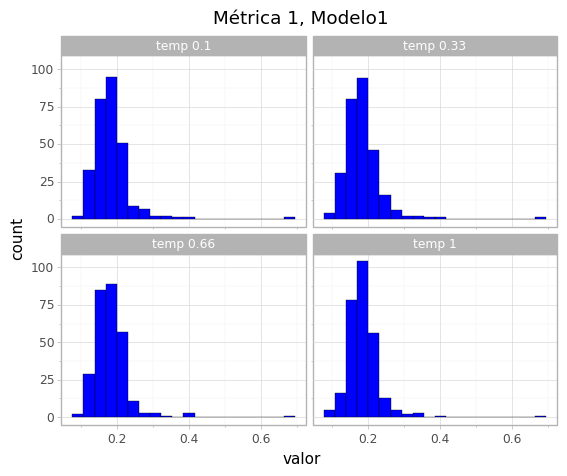

<ggplot: (8762829149809)>

In [ ]:
from plotnine import *

newm1m1=m1m1.stack().reset_index()
newm1m1.columns=['renglon','temp','valor']
(
    ggplot(newm1m1,aes(x='valor' ))
    +geom_histogram(bins=20,color='black',fill='blue',size=0.15)
    +facet_wrap('temp')
    +theme_light()
    +labs(title='Métrica 1, Modelo1')
 
)

vemos en los 4 graficos que los 4 temp tienen una distribuión similar, vamos a realizar prubas U de Mann-Whitney para comprobarlo, donde la hipotesis nula $H_0$ establece que las distribuciones de ambos grupos a comparar es la misma 

In [ ]:
import scipy.stats as stats 
res=[]
test=stats.mannwhitneyu(m1m1['temp 0.1'],m1m1['temp 0.33'])
res.append(['temp 0.1','temp 0.33',test.pvalue])
test=stats.mannwhitneyu(m1m1['temp 0.1'],m1m1['temp 0.66'])
res.append(['temp 0.1','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m1m1['temp 0.1'],m1m1['temp 1'])
res.append(['temp 0.1','temp 1',test.pvalue])
test=stats.mannwhitneyu(m1m1['temp 0.33'],m1m1['temp 0.66'])
res.append(['temp 0.33','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m1m1['temp 0.33'],m1m1['temp 1'])
res.append(['temp 0.33','temp 1',test.pvalue])
test=stats.mannwhitneyu(m1m1['temp 0.66'],m1m1['temp 1'])
res.append(['temp 0.66','temp 1',test.pvalue])


res=pd.DataFrame(res, columns=['temp1','temp2','pvalue'])
res

,temp1,temp2,pvalue
0,temp 0.1,temp 0.33,0.437022
1,temp 0.1,temp 0.66,0.445193
2,temp 0.1,temp 1,0.059659
3,temp 0.33,temp 0.66,0.394465
4,temp 0.33,temp 1,0.046469
5,temp 0.66,temp 1,0.081160


Con una significancia de $\alpha=0.025$, no se rechaza la hipotesis nula en ningun caso, y ahora podemos considerar las distribuciones como una misma y obtener estadídticas a partir te ella 




In [ ]:
est1=newm1m1['valor'].describe()
est1

count    1136.000000
mean        0.184882
std         0.050072
min         0.080645
25%         0.156842
50%         0.178571
75%         0.203157
max         0.666667
Name: valor, dtype: float64

### Metrica 1, Modelo 2

In [ ]:
m1m2.head()

,temp 0.1,temp 0.33,temp 0.66,temp 1
0,0.084630,0.149030,0.171783,0.141441
1,0.141747,0.179138,0.129359,0.113784
2,0.151721,0.114091,0.143679,0.155000
3,0.138183,0.133248,0.223293,0.185000
4,0.071279,0.097857,0.142500,0.124960


Primero vamos a revisar las estaísticas para el modelo 2  utilizano la metrica 1

In [ ]:
print(m1m2['temp 0.1'].describe())
print(m1m2['temp 0.33'].describe())
print(m1m2['temp 0.66'].describe())
print(m1m2['temp 1'].describe())

count    284.000000
mean       0.157148
std        0.038147
min        0.071279
25%        0.133571
50%        0.151575
75%        0.177222
max        0.305000
Name: temp 0.1, dtype: float64
count    284.000000
mean       0.153618
std        0.032955
min        0.045909
25%        0.134944
50%        0.150122
75%        0.171091
max        0.300455
Name: temp 0.33, dtype: float64
count    284.000000
mean       0.159883
std        0.037908
min        0.082820
25%        0.135419
50%        0.155000
75%        0.181310
max        0.288333
Name: temp 0.66, dtype: float64
count    284.000000
mean       0.155957
std        0.035424
min        0.063108
25%        0.133006
50%        0.152563
75%        0.177390
max        0.299828
Name: temp 1, dtype: float64


Podemos ver de nuevo que las estadísticas son similares para los 4 diferentes temp, ahora vamos a relizar los histogramas para cada temp

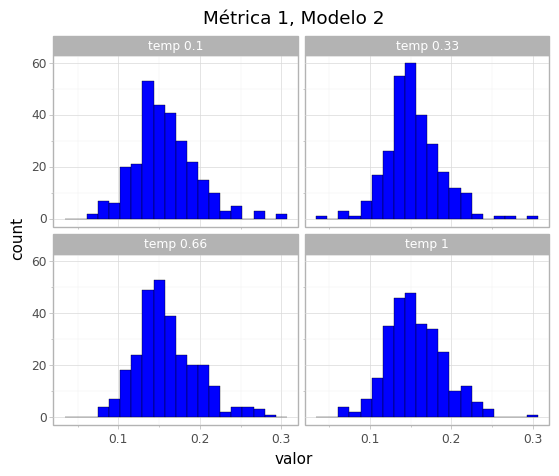

<ggplot: (8762802950509)>

In [ ]:


newm1m2=m1m2.stack().reset_index()
newm1m2.columns=['renglon','temp','valor']
(
    ggplot(newm1m2,aes(x='valor'))
    +geom_histogram(bins=20,color='black',fill='blue',size=0.15)
    +facet_wrap('temp')
    +theme_light()
    +labs(title='Métrica 1, Modelo 2')
 
)

vemos en los 4 graficos que los 4 temp tienen una distribuión similar, vamos a realizar prubas U de Mann-Whitney para comprobarlo

In [ ]:
import scipy.stats as stats 
res=[]
test=stats.mannwhitneyu(m1m2['temp 0.1'],m1m2['temp 0.33'])
res.append(['temp 0.1','temp 0.33',test.pvalue])
test=stats.mannwhitneyu(m1m2['temp 0.1'],m1m2['temp 0.66'])
res.append(['temp 0.1','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m1m2['temp 0.1'],m1m2['temp 1'])
res.append(['temp 0.1','temp 1',test.pvalue])
test=stats.mannwhitneyu(m1m2['temp 0.33'],m1m2['temp 0.66'])
res.append(['temp 0.33','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m1m2['temp 0.33'],m1m2['temp 1'])
res.append(['temp 0.33','temp 1',test.pvalue])
test=stats.mannwhitneyu(m1m2['temp 0.66'],m1m2['temp 1'])
res.append(['temp 0.66','temp 1',test.pvalue])


res=pd.DataFrame(res, columns=['temp1','temp2','pvalue'])
res

,temp1,temp2,pvalue
0,temp 0.1,temp 0.33,0.206923
1,temp 0.1,temp 0.66,0.250818
2,temp 0.1,temp 1,0.463433
3,temp 0.33,temp 0.66,0.065646
4,temp 0.33,temp 1,0.228894
5,temp 0.66,temp 1,0.217823


Con una significancia de $\alpha=0.025$, no se rechaza la hipotesis nula en ningun caso, y ahora podemos considerar las distribuciones como una misma y obtener estadídticas a partir te ella 





In [ ]:
est2=newm1m2['valor'].describe()
est2

count    1136.000000
mean        0.156652
std         0.036193
min         0.045909
25%         0.134583
50%         0.152245
75%         0.177222
max         0.305000
Name: valor, dtype: float64

### Metrica 1, Modelo 3

In [ ]:
m1m3.head()

,temp 0.1,temp 0.33,temp 0.66,temp 1
0,0.240000,0.223529,0.232877,0.192000
1,0.233129,0.208556,0.232558,0.188976
2,0.265193,0.250000,0.222222,0.208791
3,0.247863,0.241071,0.306122,0.312500
4,0.239766,0.241667,0.224490,0.142857


Primero vamos a revisar las estaísticas para el modelo 3 utilizano la metrica 1

In [ ]:
print(m1m3['temp 0.1'].describe())
print(m1m3['temp 0.33'].describe())
print(m1m3['temp 0.66'].describe())
print(m1m3['temp 1'].describe())

count    284.000000
mean       0.241028
std        0.042142
min        0.140351
25%        0.210726
50%        0.238095
75%        0.264828
max        0.352000
Name: temp 0.1, dtype: float64
count    284.000000
mean       0.241766
std        0.046657
min        0.125000
25%        0.210526
50%        0.239094
75%        0.264602
max        0.423077
Name: temp 0.33, dtype: float64
count    284.000000
mean       0.241002
std        0.045882
min        0.060606
25%        0.214286
50%        0.240072
75%        0.265386
max        0.418605
Name: temp 0.66, dtype: float64
count    284.000000
mean       0.223688
std        0.047961
min        0.121951
25%        0.195070
50%        0.218416
75%        0.243973
max        0.500000
Name: temp 1, dtype: float64


Podemos ver que las estadísticas son similares para los 4 diferentes temp, ahora vamos a relizar los histogramos para cada temp

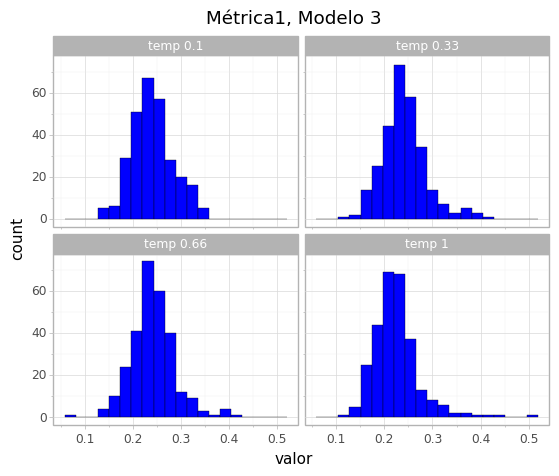

<ggplot: (8762802831381)>

In [ ]:


newm1m3=m1m3.stack().reset_index()
newm1m3.columns=['renglon','temp','valor']
(
    ggplot(newm1m3,aes(x='valor'))
    +geom_histogram(bins=20,color='black',fill='blue',size=0.15)
    +facet_wrap('temp')
    +theme_light()
    +labs(title='Métrica1, Modelo 3')
 
)

vemos en los 4 graficos que los 4 temp tienen una distribuión similar, vamos a realizar prubas U de Mann-Whitney para comprobarlo, donde la hipotesis nula $H_0$ establece que las distribuciones de ambos grupos a comparar es la misma 

In [ ]:
import scipy.stats as stats 
res=[]
test=stats.mannwhitneyu(m1m3['temp 0.1'],m1m3['temp 0.33'])
res.append(['temp 0.1','temp 0.33',test.pvalue])
test=stats.mannwhitneyu(m1m3['temp 0.1'],m1m3['temp 0.66'])
res.append(['temp 0.1','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m1m3['temp 0.1'],m1m3['temp 1'])
res.append(['temp 0.1','temp 1',test.pvalue])
test=stats.mannwhitneyu(m1m3['temp 0.33'],m1m3['temp 0.66'])
res.append(['temp 0.33','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m1m3['temp 0.33'],m1m3['temp 1'])
res.append(['temp 0.33','temp 1',test.pvalue])
test=stats.mannwhitneyu(m1m3['temp 0.66'],m1m3['temp 1'])
res.append(['temp 0.66','temp 1',test.pvalue])


res=pd.DataFrame(res, columns=['temp1','temp2','pvalue'])
res

,temp1,temp2,pvalue
0,temp 0.1,temp 0.33,4.971440e-01
1,temp 0.1,temp 0.66,4.839902e-01
2,temp 0.1,temp 1,6.708693e-09
3,temp 0.33,temp 0.66,4.691248e-01
4,temp 0.33,temp 1,7.800400e-09
5,temp 0.66,temp 1,3.459358e-09


Con una significancia de $\alpha=0.025$, no se rechaza la hipotesis nula de que temp 0.1, temp 0.33 y temp 0.66 siguen una misma distribución, pero se rechaza la hipotesis de que temp 1 sigue la misma distribucion a las demas, vamos obtener 



In [ ]:
est31=newm1m3[newm1m3.temp !='temp 1']['valor'].describe()
est31

count    852.000000
mean       0.241265
std        0.044885
min        0.060606
25%        0.211517
50%        0.239130
75%        0.265222
max        0.423077
Name: valor, dtype: float64

In [ ]:
est32=newm1m3[newm1m3.temp =='temp 1']['valor'].describe()
est32

count    284.000000
mean       0.223688
std        0.047961
min        0.121951
25%        0.195070
50%        0.218416
75%        0.243973
max        0.500000
Name: valor, dtype: float64

### Metrica 1, Modelo 4


In [ ]:
m1m4.head()

,temp 0.1,temp 0.33,temp 0.66,temp 1
0,0.252874,0.148148,0.216630,0.210526
1,0.259259,0.186441,0.248538,0.232558
2,0.233645,0.211765,0.240196,0.195652
3,0.234375,0.250000,0.105263,0.211073
4,0.199063,0.160377,0.391304,0.212766


Primero vamos a revisar las estaísticas para el modelo 4 utilizano la metrica 1

In [ ]:
print(m1m4['temp 0.1'].describe())
print(m1m4['temp 0.33'].describe())
print(m1m4['temp 0.66'].describe())
print(m1m4['temp 1'].describe())

count    284.000000
mean       0.227989
std        0.031910
min        0.107438
25%        0.210091
50%        0.227182
75%        0.243605
max        0.342105
Name: temp 0.1, dtype: float64
count    284.000000
mean       0.227417
std        0.034394
min        0.103448
25%        0.208985
50%        0.225579
75%        0.246485
max        0.375000
Name: temp 0.33, dtype: float64
count    284.000000
mean       0.226588
std        0.032436
min        0.105263
25%        0.207118
50%        0.225421
75%        0.244151
max        0.391304
Name: temp 0.66, dtype: float64
count    284.000000
mean       0.230002
std        0.033641
min        0.134615
25%        0.210431
50%        0.227393
75%        0.248309
max        0.379310
Name: temp 1, dtype: float64


Podemos ver que las estadísticas son similares para los 4 diferentes temp, ahora vamos a relizar los histogramos para cada temp

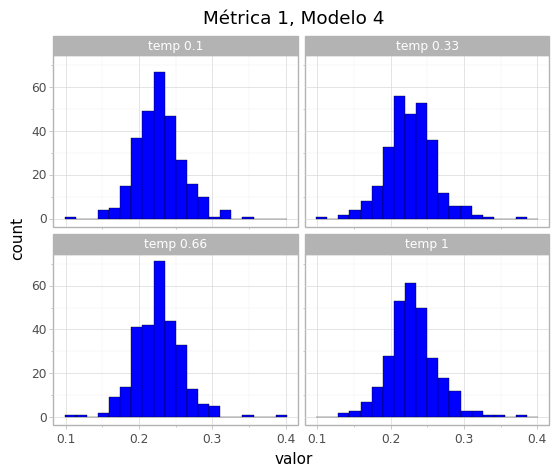

<ggplot: (8762802945685)>

In [ ]:

newm1m4=m1m4.stack().reset_index()
newm1m4.columns=['renglon','temp','valor']
(
    ggplot(newm1m4,aes(x='valor'))
    +geom_histogram(bins=20,color='black',fill='blue',size=0.15)
    +facet_wrap('temp')
    +theme_light()
    +labs(title='Métrica 1, Modelo 4')
 
)

vemos en los 4 graficos que los 4 temp tienen una distribuión similar, vamos a realizar prubas U de Mann-Whitney para comprobarlo, donde la hipotesis nula $H_0$ establece que las distribuciones de ambos grupos a comparar es la misma 

In [ ]:
import scipy.stats as stats 
res=[]
test=stats.mannwhitneyu(m1m4['temp 0.1'],m1m4['temp 0.33'])
res.append(['temp 0.1','temp 0.33',test.pvalue])
test=stats.mannwhitneyu(m1m4['temp 0.1'],m1m4['temp 0.66'])
res.append(['temp 0.1','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m1m4['temp 0.1'],m1m4['temp 1'])
res.append(['temp 0.1','temp 1',test.pvalue])
test=stats.mannwhitneyu(m1m4['temp 0.33'],m1m4['temp 0.66'])
res.append(['temp 0.33','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m1m4['temp 0.33'],m1m4['temp 1'])
res.append(['temp 0.33','temp 1',test.pvalue])
test=stats.mannwhitneyu(m1m4['temp 0.66'],m1m4['temp 1'])
res.append(['temp 0.66','temp 1',test.pvalue])


res=pd.DataFrame(res, columns=['temp1','temp2','pvalue'])
res

,temp1,temp2,pvalue
0,temp 0.1,temp 0.33,0.445498
1,temp 0.1,temp 0.66,0.311206
2,temp 0.1,temp 1,0.279966
3,temp 0.33,temp 0.66,0.388673
4,temp 0.33,temp 1,0.228819
5,temp 0.66,temp 1,0.145613


Con una significancia de $\alpha=0.025$, no se rechaza la hipotesis nula en ningun caso, y ahora podemos considerar las distribuciones como una misma y obtener estadídticas a partir te ella 




In [ ]:
est4=newm1m4['valor'].describe()
est4

count    1136.000000
mean        0.227999
std         0.033090
min         0.103448
25%         0.209179
50%         0.227072
75%         0.245833
max         0.391304
Name: valor, dtype: float64

### Metrica 1, comparacion de modelos

Tenemos 4 modelos, cada uno con 4 posibles valores para temp, para el modelo 1, 2 y 4 no hay diferencia significativa en las metricas al usar cualquiera de los distintos temp, pero para el moedelo 3 tenemos que las metricas obtenidas usando temp igual a  0.1,0.33 y 0.66 tienen la misma distribucion, la cual es diferente si usamos temp igual a 1, por lo tanto de el modelo 3, se obtienen 2 modelos, el modelo 3 con temp 0.1,0.33 o 0.66, y el modelo 3 usando temp 1

Primero vamos a comprar los estadisticos para los diferentes modelos 


In [ ]:
estadisticos=[['mean',est1['mean'],est2['mean'],est31['mean'],est32['mean'],est4['mean']]]
estadisticos.append(['std',est1['std'],est2['std'],est31['std'],est32['std'],est4['std']])
estadisticos.append(['min',est1['min'],est2['min'],est31['min'],est32['min'],est4['min']])
estadisticos.append(['25%',est1['25%'],est2['25%'],est31['25%'],est32['25%'],est4['25%']])
estadisticos.append(['50%',est1['50%'],est2['50%'],est31['50%'],est32['50%'],est4['50%']])
estadisticos.append(['75%',est1['75%'],est2['75%'],est31['75%'],est32['75%'],est4['75%']])
estadisticos.append(['max',est1['max'],est2['max'],est31['max'],est32['max'],est4['max']])

estadisticos=pd.DataFrame(estadisticos,
                          columns=['medida','modelo 1','modelo 2','modelo 3_1','modelo 3_2','modelo 4'])
estadisticos

,medida,modelo 1,modelo 2,modelo 3_1,modelo 3_2,modelo 4
0,mean,0.184882,0.156652,0.241265,0.223688,0.227999
1,std,0.050072,0.036193,0.044885,0.047961,0.033090
2,min,0.080645,0.045909,0.060606,0.121951,0.103448
3,25%,0.156842,0.134583,0.211517,0.195070,0.209179
4,50%,0.178571,0.152245,0.239130,0.218416,0.227072
5,75%,0.203157,0.177222,0.265222,0.243973,0.245833
6,max,0.666667,0.305000,0.423077,0.500000,0.391304


Podemos ver que el modelo 2 es el que tiene la madia baja, le sigue el modelo 1, sin embargo su desviación estandar es más alta que la de todo los demás, tambien su valor máximo( de 0.6666) es más alto que el valor máximo de todos los demás

Ahora vamos a realizar histogramas y boxplot para todos los modelos

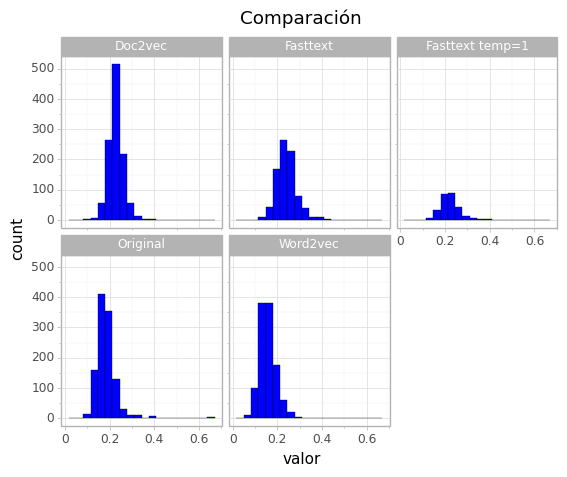

<ggplot: (8762802574177)>

In [ ]:
l1=newm1m1['valor'].to_list()
l2=newm1m2['valor'].to_list()
l3=newm1m3[newm1m3.temp !='temp 1']['valor'].to_list()
l4=newm1m3[newm1m3.temp =='temp 1']['valor'].to_list()
l5=newm1m4['valor'].to_list()

dic={'modelo':['Original']*len(l1)+['Word2vec']*len(l2)+['Fasttext']*len(l3)+
     ['Fasttext temp=1']*len(l4)+['Doc2vec']*len(l5),'valor':l1+l2+l3+l4+l5}

mods=pd.DataFrame(dic)

(
    ggplot(mods,aes(x='valor'))
    +geom_histogram(bins=20,color='black',fill='blue',size=0.15 )
    +facet_wrap('modelo')
    +theme_light()
    +labs(title='Comparación')
 
)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


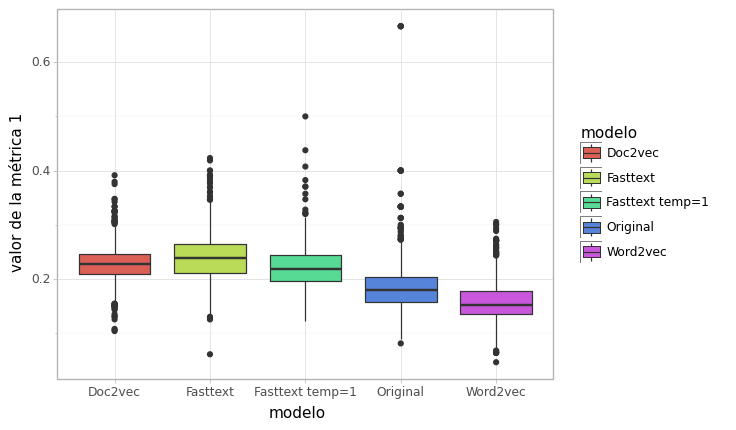

<ggplot: (8762828742717)>

In [ ]:

(
    ggplot(mods,aes(y='valor',x='modelo',fill='modelo'))
    +geom_boxplot()
    +theme_light()
    +labs(y="valor de la métrica 1")
 
)

podemos ver que para la metrica 1 el mejor modelo es el 2, pues su distribución se encuentra más cercana al 0 comparado con los otros, el modelo 1
 tambien tiene una distribución cerca de el cero pero tienes datos atipicos de 0.66 

## Metrica 2, modelo 1 

In [ ]:
m2m1=pd.read_csv('./datos/m2m1.csv')

m2m1.head()


,temp 0.1,temp 0.33,temp 0.66,temp 1
0,0.256922,0.388781,0.265481,0.273815
1,0.308431,0.185396,0.152305,0.187042
2,0.143512,0.130489,0.272753,0.110783
3,0.502184,0.372115,0.477987,0.666824
4,0.212644,0.222164,0.434458,0.303803


In [ ]:
print(m2m1['temp 0.1'].describe())
print(m2m1['temp 0.33'].describe())
print(m2m1['temp 0.66'].describe())
print(m2m1['temp 1'].describe())

count    284.000000
mean       0.196140
std        0.132267
min        0.009712
25%        0.096256
50%        0.154045
75%        0.255433
max        0.744445
Name: temp 0.1, dtype: float64
count    284.000000
mean       0.197795
std        0.130628
min        0.000000
25%        0.099758
50%        0.160172
75%        0.266997
max        0.678836
Name: temp 0.33, dtype: float64
count    284.000000
mean       0.201154
std        0.138277
min        0.006594
25%        0.101765
50%        0.156720
75%        0.268785
max        0.665267
Name: temp 0.66, dtype: float64
count    284.000000
mean       0.195649
std        0.131880
min        0.012087
25%        0.105313
50%        0.161143
75%        0.256376
max        0.828914
Name: temp 1, dtype: float64


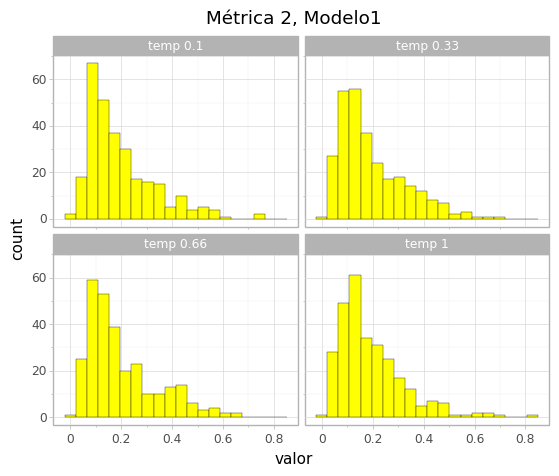

<ggplot: (8762802364973)>

In [ ]:
from plotnine import *

newm2m1=m2m1.stack().reset_index()
newm2m1.columns=['renglon','temp','valor']
(
    ggplot(newm2m1,aes(x='valor' ))
    +geom_histogram(bins=20,color='black',fill='yellow',size=0.15)
    +facet_wrap('temp')
    +theme_light()
    +labs(title='Métrica 2, Modelo1')
 
)

In [ ]:
import scipy.stats as stats 
res2=[]
test=stats.mannwhitneyu(m2m1['temp 0.1'],m2m1['temp 0.33'])
res2.append(['temp 0.1','temp 0.33',test.pvalue])
test=stats.mannwhitneyu(m2m1['temp 0.1'],m2m1['temp 0.66'])
res2.append(['temp 0.1','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m2m1['temp 0.1'],m2m1['temp 1'])
res2.append(['temp 0.1','temp 1',test.pvalue])
test=stats.mannwhitneyu(m2m1['temp 0.33'],m2m1['temp 0.66'])
res2.append(['temp 0.33','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m2m1['temp 0.33'],m2m1['temp 1'])
res2.append(['temp 0.33','temp 1',test.pvalue])
test=stats.mannwhitneyu(m2m1['temp 0.66'],m2m1['temp 1'])
res2.append(['temp 0.66','temp 1',test.pvalue])


res2=pd.DataFrame(res2, columns=['temp1','temp2','pvalue'])
res2

,temp1,temp2,pvalue
0,temp 0.1,temp 0.33,0.429281
1,temp 0.1,temp 0.66,0.422165
2,temp 0.1,temp 1,0.446105
3,temp 0.33,temp 0.66,0.489903
4,temp 0.33,temp 1,0.476656
5,temp 0.66,temp 1,0.480220


Notamos que para la metrica dos, las distribucion para el modelo 1 en cada temp es similar, y los recultados de los valores p obtenidos por la prueba Mann-Whitney U con una significancia $\alpha=0.025$ no rechazamos la hipotesis, donde $H_0$ es que las distribuciones que se comparan son las mismas

In [ ]:
est21=newm2m1['valor'].describe()
est21

count    1136.000000
mean        0.197685
std         0.133137
min         0.000000
25%         0.100077
50%         0.156408
75%         0.263327
max         0.828914
Name: valor, dtype: float64

## Metrica 2 Modelo 2

In [ ]:
m2m2=pd.read_csv('./datos/m2m2.csv')

m2m2.head()

,temp 0.1,temp 0.33,temp 0.66,temp 1
0,0.025135,0.036341,0.048834,0.035288
1,0.040713,0.070618,0.087790,0.053986
2,0.102700,0.143788,0.041397,0.064371
3,0.040780,0.013220,0.030026,0.036669
4,0.188490,0.241672,0.184659,0.290600


In [ ]:
print(m2m2['temp 0.1'].describe())
print(m2m2['temp 0.33'].describe())
print(m2m2['temp 0.66'].describe())
print(m2m2['temp 1'].describe())

count    284.000000
mean       0.099791
std        0.070790
min        0.000000
25%        0.054758
50%        0.082221
75%        0.125390
max        0.507135
Name: temp 0.1, dtype: float64
count    284.000000
mean       0.098613
std        0.071375
min        0.000000
25%        0.055919
50%        0.078231
75%        0.119721
max        0.507135
Name: temp 0.33, dtype: float64
count    284.000000
mean       0.097737
std        0.068053
min        0.000000
25%        0.053911
50%        0.083013
75%        0.118357
max        0.453782
Name: temp 0.66, dtype: float64
count    284.000000
mean       0.099983
std        0.066952
min        0.000000
25%        0.059554
50%        0.085796
75%        0.126565
max        0.532858
Name: temp 1, dtype: float64


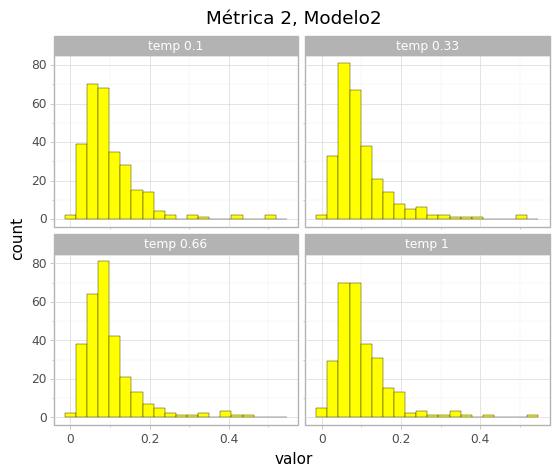

<ggplot: (8762802930893)>

In [ ]:

newm2m2=m2m2.stack().reset_index()
newm2m2.columns=['renglon','temp','valor']
(
    ggplot(newm2m2,aes(x='valor' ))
    +geom_histogram(bins=20,color='black',fill='yellow',size=0.15)
    +facet_wrap('temp')
    +theme_light()
    +labs(title='Métrica 2, Modelo2')
 
)

In [ ]:
import scipy.stats as stats 
res3=[]
test=stats.mannwhitneyu(m2m2['temp 0.1'],m2m2['temp 0.33'])
res3.append(['temp 0.1','temp 0.33',test.pvalue])
test=stats.mannwhitneyu(m2m2['temp 0.1'],m2m2['temp 0.66'])
res3.append(['temp 0.1','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m2m2['temp 0.1'],m2m2['temp 1'])
res3.append(['temp 0.1','temp 1',test.pvalue])
test=stats.mannwhitneyu(m2m2['temp 0.33'],m2m2['temp 0.66'])
res3.append(['temp 0.33','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m2m2['temp 0.33'],m2m2['temp 1'])
res3.append(['temp 0.33','temp 1',test.pvalue])
test=stats.mannwhitneyu(m2m2['temp 0.66'],m2m2['temp 1'])
res3.append(['temp 0.66','temp 1',test.pvalue])


res3=pd.DataFrame(res3, columns=['temp1','temp2','pvalue'])
res3

,temp1,temp2,pvalue
0,temp 0.1,temp 0.33,0.343495
1,temp 0.1,temp 0.66,0.407714
2,temp 0.1,temp 1,0.297697
3,temp 0.33,temp 0.66,0.387989
4,temp 0.33,temp 1,0.145616
5,temp 0.66,temp 1,0.212003


Con los resultados P para el modelo 2 con metrica 2, no rechzamos hipotesis y concluimos que todas se distribuyen igual.

In [ ]:
est22=newm2m2['valor'].describe()
est22

count    1136.000000
mean        0.099031
std         0.069232
min         0.000000
25%         0.055363
50%         0.082489
75%         0.121394
max         0.532858
Name: valor, dtype: float64

## Metrica 2 Modelo 3

In [ ]:
m2m3=pd.read_csv('./datos/m2m3.csv')

m2m3.head()

,temp 0.1,temp 0.33,temp 0.66,temp 1
0,0.038766,0.027181,0.073438,0.027181
1,0.078280,0.043342,0.044669,0.064760
2,0.140330,0.070199,0.097570,0.104043
3,0.052828,0.014308,0.026211,0.016929
4,0.102754,0.067650,0.133043,0.217714


In [ ]:
print(m2m3['temp 0.1'].describe())
print(m2m3['temp 0.33'].describe())
print(m2m3['temp 0.66'].describe())
print(m2m3['temp 1'].describe())

count    284.000000
mean       0.081153
std        0.054717
min        0.000000
25%        0.043358
50%        0.070387
75%        0.100514
max        0.376340
Name: temp 0.1, dtype: float64
count    284.000000
mean       0.077891
std        0.046578
min        0.000000
25%        0.046458
50%        0.068912
75%        0.097303
max        0.275245
Name: temp 0.33, dtype: float64
count    284.000000
mean       0.084078
std        0.057074
min        0.000000
25%        0.045550
50%        0.069435
75%        0.107313
max        0.362191
Name: temp 0.66, dtype: float64
count    284.000000
mean       0.076984
std        0.044307
min        0.000000
25%        0.046091
50%        0.069817
75%        0.097165
max        0.304539
Name: temp 1, dtype: float64


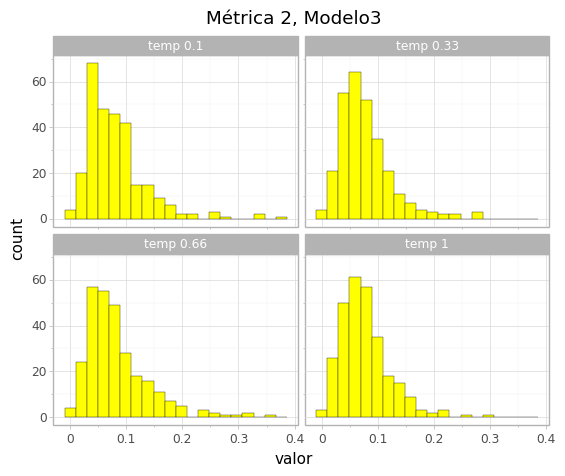

<ggplot: (8762802221929)>

In [ ]:
newm2m3=m2m3.stack().reset_index()
newm2m3.columns=['renglon','temp','valor']
(
    ggplot(newm2m3,aes(x='valor' ))
    +geom_histogram(bins=20,color='black',fill='yellow',size=0.15)
    +facet_wrap('temp')
    +theme_light()
    +labs(title='Métrica 2, Modelo3')
 
)

In [ ]:
res4=[]
test=stats.mannwhitneyu(m2m3['temp 0.1'],m2m3['temp 0.33'])
res4.append(['temp 0.1','temp 0.33',test.pvalue])
test=stats.mannwhitneyu(m2m3['temp 0.1'],m2m3['temp 0.66'])
res4.append(['temp 0.1','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m2m3['temp 0.1'],m2m3['temp 1'])
res4.append(['temp 0.1','temp 1',test.pvalue])
test=stats.mannwhitneyu(m2m3['temp 0.33'],m2m3['temp 0.66'])
res4.append(['temp 0.33','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m2m3['temp 0.33'],m2m3['temp 1'])
res4.append(['temp 0.33','temp 1',test.pvalue])
test=stats.mannwhitneyu(m2m3['temp 0.66'],m2m3['temp 1'])
res4.append(['temp 0.66','temp 1',test.pvalue])


res4=pd.DataFrame(res4, columns=['temp1','temp2','pvalue'])
res4

,temp1,temp2,pvalue
0,temp 0.1,temp 0.33,0.426271
1,temp 0.1,temp 0.66,0.311208
2,temp 0.1,temp 1,0.424067
3,temp 0.33,temp 0.66,0.241873
4,temp 0.33,temp 1,0.481443
5,temp 0.66,temp 1,0.236952


Con los resultados P para el modelo 3 con metrica 2, no rechzamos hipotesis y concluimos que todas se distribuyen igual.

In [ ]:
est23=newm2m3['valor'].describe()
est23

count    1136.000000
mean        0.080026
std         0.050961
min         0.000000
25%         0.045440
50%         0.069471
75%         0.100346
max         0.376340
Name: valor, dtype: float64

## Metrica 2 Modelo 4

In [ ]:
m2m4=pd.read_csv('./datos/m2m4.csv')

m2m4.head()

,temp 0.1,temp 0.33,temp 0.66,temp 1
0,0.049386,0.037627,0.030816,0.022990
1,0.048584,0.052902,0.081728,0.055949
2,0.126428,0.149822,0.122358,0.129616
3,0.040015,0.076112,0.036206,0.020527
4,0.085765,0.071904,0.084713,0.073456


In [ ]:
print(m2m4['temp 0.1'].describe())
print(m2m4['temp 0.33'].describe())
print(m2m4['temp 0.66'].describe())
print(m2m4['temp 1'].describe())

count    284.000000
mean       0.097101
std        0.058393
min        0.000000
25%        0.060152
50%        0.085763
75%        0.122421
max        0.397234
Name: temp 0.1, dtype: float64
count    284.000000
mean       0.102621
std        0.058050
min        0.000000
25%        0.060128
50%        0.095852
75%        0.134519
max        0.316476
Name: temp 0.33, dtype: float64
count    284.000000
mean       0.095462
std        0.057018
min        0.000000
25%        0.054620
50%        0.081689
75%        0.123098
max        0.368236
Name: temp 0.66, dtype: float64
count    284.000000
mean       0.096449
std        0.057913
min        0.000000
25%        0.055074
50%        0.082302
75%        0.127723
max        0.333627
Name: temp 1, dtype: float64


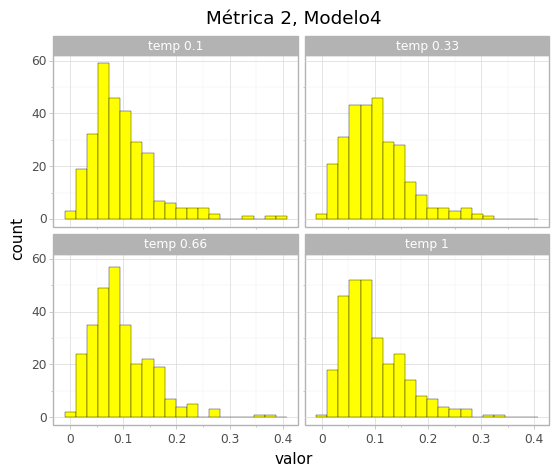

<ggplot: (8762801857049)>

In [ ]:
newm2m4=m2m4.stack().reset_index()
newm2m4.columns=['renglon','temp','valor']
(
    ggplot(newm2m4,aes(x='valor' ))
    +geom_histogram(bins=20,color='black',fill='yellow',size=0.15)
    +facet_wrap('temp')
    +theme_light()
    +labs(title='Métrica 2, Modelo4')
 
)

In [ ]:
res5=[]
test=stats.mannwhitneyu(m2m4['temp 0.1'],m2m4['temp 0.33'])
res5.append(['temp 0.1','temp 0.33',test.pvalue])
test=stats.mannwhitneyu(m2m4['temp 0.1'],m2m4['temp 0.66'])
res5.append(['temp 0.1','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m2m4['temp 0.1'],m2m4['temp 1'])
res5.append(['temp 0.1','temp 1',test.pvalue])
test=stats.mannwhitneyu(m2m4['temp 0.33'],m2m4['temp 0.66'])
res5.append(['temp 0.33','temp 0.66',test.pvalue])
test=stats.mannwhitneyu(m2m4['temp 0.33'],m2m4['temp 1'])
res5.append(['temp 0.33','temp 1',test.pvalue])
test=stats.mannwhitneyu(m2m4['temp 0.66'],m2m4['temp 1'])
res5.append(['temp 0.66','temp 1',test.pvalue])


res5=pd.DataFrame(res5, columns=['temp1','temp2','pvalue'])
res5

,temp1,temp2,pvalue
0,temp 0.1,temp 0.33,0.075121
1,temp 0.1,temp 0.66,0.346510
2,temp 0.1,temp 1,0.321398
3,temp 0.33,temp 0.66,0.036627
4,temp 0.33,temp 1,0.041529
5,temp 0.66,temp 1,0.480832


En la prueba final, para la metrica 2 modelo 4, en ninguno de los casos se rechaza la hipotesis

In [ ]:
est24=newm2m4['valor'].describe()
est24

count    1136.000000
mean        0.097908
std         0.057836
min         0.000000
25%         0.057534
50%         0.086349
75%         0.127832
max         0.397234
Name: valor, dtype: float64

## Comparacion de la metrica dos con los 4 modelos

In [ ]:
estadisticos=[['mean',est21['mean'],est22['mean'],est23['mean'],est24['mean']]]
estadisticos.append(['std',est21['std'],est22['std'],est23['std'],est24['std']])
estadisticos.append(['min',est21['min'],est22['min'],est23['min'],est24['min']])
estadisticos.append(['25%',est21['25%'],est22['25%'],est23['25%'],est24['25%']])
estadisticos.append(['50%',est21['50%'],est22['50%'],est23['50%'],est24['50%']])
estadisticos.append(['75%',est21['75%'],est22['75%'],est23['75%'],est24['75%']])
estadisticos.append(['max',est21['max'],est22['max'],est23['max'],est24['max']])

estadisticos=pd.DataFrame(estadisticos, columns=['medida','modelo 1','modelo 2','modelo 3','modelo 4'])
estadisticos

,medida,modelo 1,modelo 2,modelo 3,modelo 4
0,mean,0.197685,0.099031,0.080026,0.097908
1,std,0.133137,0.069232,0.050961,0.057836
2,min,0.000000,0.000000,0.000000,0.000000
3,25%,0.100077,0.055363,0.045440,0.057534
4,50%,0.156408,0.082489,0.069471,0.086349
5,75%,0.263327,0.121394,0.100346,0.127832
6,max,0.828914,0.532858,0.376340,0.397234


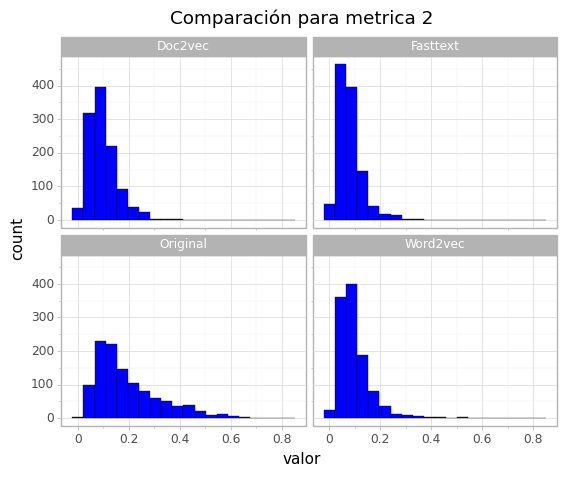

<ggplot: (8762802000397)>

In [ ]:
m1=newm2m1['valor'].to_list()
m2=newm2m2['valor'].to_list()
m3=newm2m3['valor'].to_list()
m4=newm2m4['valor'].to_list()

dic={'modelo':['Original']*len(m1)+['Word2vec']*len(m2)+['Fasttext']*len(m3)+
     ['Doc2vec']*len(m4),'valor':m1+m2+m3+m4}

mods2=pd.DataFrame(dic)

(
    ggplot(mods2,aes(x='valor'))
    +geom_histogram(bins=20,color='black',fill='blue',size=0.15 )
    +facet_wrap('modelo')
    +theme_light()
    +labs(title='Comparación para metrica 2')
 
)


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


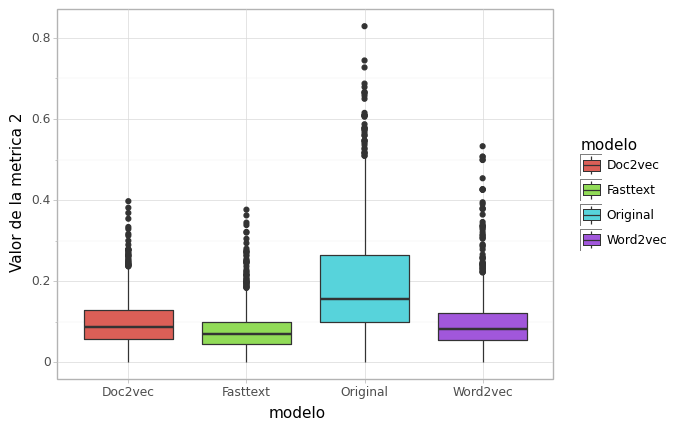

<ggplot: (8762801734405)>

In [ ]:
(
    ggplot(mods2,aes(y='valor',x='modelo',fill='modelo'))
    +geom_boxplot()
    +theme_light()
    +labs( y ="Valor de la metrica 2")
 
)

Si concideramos los resultados por la metrica dos, donde recordamos que se utiliza para encontrar que tanta similitud hay entre los textos, notamos que el modelo 3, con FASTEXT es el mejor de los casos ya que su valor es más cercano a 0.